## 패키지

In [1]:
import pandas as pd
import numpy as np

import re
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

## 1. 전처리 함수

In [2]:
def drop_columns(data, columns : list):
    '''불필요 속성 제거 함수'''
    for i in columns:
        data = data.drop(i, axis=1)
        
    return data

In [3]:
def apply_brand(x):
    x = re.sub('[^a-zA-Z]', '', x)
    
    return x

def apply_brand_change(x):
    if x in ['IVM', 'MANVOLKSWAGEN', 'Scania', 'JMC']:
        x = 'low_price_brand'
    elif x in ['GAC', 'GMC', 'Mitsubishi', 'Pontiac', 'Chevrolet', 'Isuzu', 'Peugeot', 'Volvo', 'Kia', 'Acura', 'Hyundai',
              'IVECO', 'Lincoln', 'Toyota', 'Honda']:
        x = 'midle_price_brand'
    elif x in ['Porsche', 'Jaguar', 'MINI', 'Ford', 'Volkswagen', 'BMW', 'Lexus', 'Bentley', 'MercedesBenz', 'Mazda',
              'Nissan', 'Infiniti', 'Jeep']:
        x = 'high_price_brand'
    elif x in ['Land', 'ALPINA', 'Iveco', 'DAF', 'Man']:
        x = 'very_high_price_brand'
    elif x in ['Mack', 'Audi', 'Dodge', 'RollsRoyce']:
        x = 'top_price_brand'
    else:
        x = 'midle_price_brand'

def preprocessing_title(data):
    '''title 전처리 함수'''
    
    # 'brand' 파생변수 생성
    data['brand'] = data['title'].apply(lambda x : x.split()[0])
    data['brand'] = data['brand'].apply(apply_brand)
    # title 삭제
    data = data.drop('title', axis=1)
    
    # EDA 분석의 결과를 참고하여 비슷한 가격대의 브랜드끼리는 묶는다.
    data.brand = data.brand.apply(apply_brand_change)
    
    return data

In [4]:
def apply_engine(x):
    '''engine apply 함수'''
    silinder_n = int(re.sub('[^0-9]', '', x[:2])) # 실린더 개수
    silinder_version = re.findall('\(([^)]+)', x)[0] # 실린더 종류
    silinder_version = re.sub('[^a-zA-Z]', '', silinder_version)
    
    if silinder_n >= 6 and silinder_version == 'V':
        x = 'high_price_silinder'
    elif silinder_n >= 4 and silinder_version == 'I':
        x = 'midle_price_silinder'
    else:
        x = 'low_price_silinder'
    
    return x

def proprecessing_engine(data):
    '''engine 전처리 함수'''
    
    data.engine = data.engine.apply(apply_engine)
    
    return data

In [5]:
def preprocessing_year(data):
    '''year 전처리 함수'''
    
    # 비정상적인 연도는 주행거리를 통해 유추
    for i in data.loc[(data['year'] < 1900) | (data['year'] > 2022), ].index:
        data.loc[i, 'year'] = 2022 - data.loc[i, 'odometer'] // 15000
    
    return data

## 2. 데이터 전처리

In [6]:
# 데이터 로드
train_df = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')

In [7]:
# train data : X, y 분리
X_data = train_df.iloc[:, :-1]
y_data = train_df.iloc[:, -1]

In [8]:
# X 전처리
X_data = drop_columns(X_data, ['id', 'paint', 'location'])
X_data = preprocessing_title(X_data)
X_data = preprocessing_year(X_data)
X_data = pd.get_dummies(X_data, ['isimported', 'engine', 'brand', 'fuel', 'transmission'])
mms = MinMaxScaler()
X_data = mms.fit_transform(X_data)

In [9]:
t_x, tt_x, t_y, tt_y = train_test_split(X_data, y_data, random_state=42, test_size=0.3)
t_x, v_x, t_y, v_y = train_test_split(t_x, t_y, random_state=42, test_size=0.3)

## 3. 모델 생성 및 학습

In [28]:
e_st = EarlyStopping(monitor='val_mae', mode='min', patience=100, restore_best_weights=True)

model = keras.models.Sequential()
model.add(Dense(17 * 17, input_dim=t_x.shape[1], activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(17 * 17 * 2, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(34, activation='relu'))
model.add(Dense(17 * 17, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dense(1))

('rgr', rgr), ('sgdr', sgdr), ('gbr', gbr), ('lsr', lsr)

In [29]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=tf.losses.mean_squared_error, metrics=['mae'])
history_m = model.fit(t_x, t_y, epochs=10000, validation_data=(v_x, v_y), callbacks=[e_st], batch_size = 128)

Epoch 1/10000
4/4 [==============================] - 0s 42ms/step - loss: 209649986961408.0000 - mae: 8339882.5000 - val_loss: 156981440544768.0000 - val_mae: 6900623.0000
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 209636414193664.0000 - mae: 8339053.0000 - val_loss: 156940185370624.0000 - val_mae: 6897663.0000
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 209527345512448.0000 - mae: 8332673.0000 - val_loss: 156720722608128.0000 - val_mae: 6881865.5000
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 209069965049856.0000 - mae: 8305361.5000 - val_loss: 155943450968064.0000 - val_mae: 6825568.0000
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 207535151775744.0000 - mae: 8217451.0000 - val_loss: 153768570126336.0000 - val_mae: 6665519.0000
Epoch 6/10000
4/4 [==============================] - 0s 16ms/step - loss: 203812438540288.0000 - mae: 7987244.5000 - val_loss: 1486780104704

Epoch 49/10000
4/4 [==============================] - 0s 11ms/step - loss: 83307593203712.0000 - mae: 4347062.5000 - val_loss: 52214873718784.0000 - val_mae: 3726198.5000
Epoch 50/10000
4/4 [==============================] - 0s 12ms/step - loss: 82252859965440.0000 - mae: 4456387.0000 - val_loss: 51786308124672.0000 - val_mae: 3680776.5000
Epoch 51/10000
4/4 [==============================] - 0s 11ms/step - loss: 81865599877120.0000 - mae: 4422575.0000 - val_loss: 51179010654208.0000 - val_mae: 3597057.0000
Epoch 52/10000
4/4 [==============================] - 0s 11ms/step - loss: 81884491022336.0000 - mae: 4285425.0000 - val_loss: 50583935385600.0000 - val_mae: 3473023.7500
Epoch 53/10000
4/4 [==============================] - 0s 14ms/step - loss: 81182549082112.0000 - mae: 4275789.5000 - val_loss: 50721911209984.0000 - val_mae: 3558885.0000
Epoch 54/10000
4/4 [==============================] - 0s 16ms/step - loss: 80760065228800.0000 - mae: 4354152.5000 - val_loss: 50759768997888.000

4/4 [==============================] - 0s 11ms/step - loss: 64444969254912.0000 - mae: 3547322.0000 - val_loss: 41939130908672.0000 - val_mae: 2857896.0000
Epoch 97/10000
4/4 [==============================] - 0s 11ms/step - loss: 64218913046528.0000 - mae: 3546835.7500 - val_loss: 44406421848064.0000 - val_mae: 3235228.0000
Epoch 98/10000
4/4 [==============================] - 0s 12ms/step - loss: 64841855270912.0000 - mae: 4016304.2500 - val_loss: 43871174131712.0000 - val_mae: 3184442.2500
Epoch 99/10000
4/4 [==============================] - 0s 15ms/step - loss: 64488795537408.0000 - mae: 3547274.7500 - val_loss: 41013817114624.0000 - val_mae: 2714030.5000
Epoch 100/10000
4/4 [==============================] - 0s 15ms/step - loss: 64314144718848.0000 - mae: 3386400.5000 - val_loss: 42634198384640.0000 - val_mae: 3110345.2500
Epoch 101/10000
4/4 [==============================] - 0s 12ms/step - loss: 67069861167104.0000 - mae: 4248723.0000 - val_loss: 46907757953024.0000 - val_mae: 

Epoch 144/10000
4/4 [==============================] - 0s 11ms/step - loss: 54855045480448.0000 - mae: 3356014.0000 - val_loss: 31789739409408.0000 - val_mae: 2733463.2500
Epoch 145/10000
4/4 [==============================] - 0s 10ms/step - loss: 54478594113536.0000 - mae: 3329586.7500 - val_loss: 31664692527104.0000 - val_mae: 2802125.5000
Epoch 146/10000
4/4 [==============================] - 0s 13ms/step - loss: 54913631518720.0000 - mae: 3324395.5000 - val_loss: 29984601145344.0000 - val_mae: 2645358.0000
Epoch 147/10000
4/4 [==============================] - 0s 14ms/step - loss: 54402245197824.0000 - mae: 3345062.0000 - val_loss: 30620948365312.0000 - val_mae: 2754461.2500
Epoch 148/10000
4/4 [==============================] - 0s 14ms/step - loss: 54329201393664.0000 - mae: 3414341.2500 - val_loss: 30605133742080.0000 - val_mae: 2722433.7500
Epoch 149/10000
4/4 [==============================] - 0s 15ms/step - loss: 54286838923264.0000 - mae: 3264045.2500 - val_loss: 306436647157

4/4 [==============================] - 0s 14ms/step - loss: 52613773000704.0000 - mae: 3279102.5000 - val_loss: 29982969561088.0000 - val_mae: 2767214.5000
Epoch 192/10000
4/4 [==============================] - 0s 15ms/step - loss: 52456557903872.0000 - mae: 3419417.7500 - val_loss: 29700768399360.0000 - val_mae: 2729280.2500
Epoch 193/10000
4/4 [==============================] - 0s 16ms/step - loss: 51697946722304.0000 - mae: 3288604.5000 - val_loss: 28945393123328.0000 - val_mae: 2571116.7500
Epoch 194/10000
4/4 [==============================] - 0s 15ms/step - loss: 52172288950272.0000 - mae: 3160724.5000 - val_loss: 28676051697664.0000 - val_mae: 2561806.5000
Epoch 195/10000
4/4 [==============================] - 0s 12ms/step - loss: 55021831979008.0000 - mae: 3155477.7500 - val_loss: 28351605506048.0000 - val_mae: 2564353.7500
Epoch 196/10000
4/4 [==============================] - 0s 12ms/step - loss: 52692491698176.0000 - mae: 3428588.0000 - val_loss: 34249191194624.0000 - val_ma

Epoch 239/10000
4/4 [==============================] - 0s 16ms/step - loss: 51700446527488.0000 - mae: 3106733.0000 - val_loss: 29515044618240.0000 - val_mae: 2732813.0000
Epoch 240/10000
4/4 [==============================] - 0s 22ms/step - loss: 51642556743680.0000 - mae: 3357093.7500 - val_loss: 30276843470848.0000 - val_mae: 2835568.5000
Epoch 241/10000
4/4 [==============================] - 0s 16ms/step - loss: 52338647629824.0000 - mae: 3256401.5000 - val_loss: 27567818014720.0000 - val_mae: 2470512.0000
Epoch 242/10000
4/4 [==============================] - 0s 12ms/step - loss: 51350058565632.0000 - mae: 3059065.0000 - val_loss: 28340121501696.0000 - val_mae: 2615281.5000
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 51095145545728.0000 - mae: 3315220.7500 - val_loss: 30741102592000.0000 - val_mae: 2904666.5000
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 51684583669760.0000 - mae: 3331129.2500 - val_loss: 284308631715

## 4. 모델 평가 및 검증

In [30]:
model.evaluate(tt_x, tt_y)

10/10 [==============================] - 0s 2ms/step - loss: 136764744269824.0000 - mae: 3943680.0000


[136764744269824.0, 3943680.0]

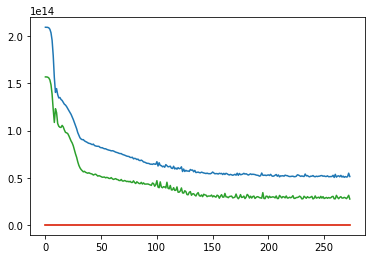

In [31]:
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_m.history))
plt.show()

## 5. 최종 모델 생성 및 학습

In [13]:
model = RandomForestRegressor()
model.fit(X_data, y_data)

RandomForestRegressor()

In [14]:
e_st = EarlyStopping(monitor='mae', mode='min', patience=100, restore_best_weights=True)

model = keras.models.Sequential()
model.add(Dense(34, input_dim=t_x.shape[1], activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(68, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(34, activation='relu'))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=tf.losses.mean_squared_error, metrics=['mae'])
history_m = model.fit(X_data, y_data, epochs=10000, callbacks=[e_st], batch_size = 128)

Epoch 1/10000
8/8 [==============================] - 0s 2ms/step - loss: 221451701452800.0000 - mae: 8243200.5000
Epoch 2/10000
8/8 [==============================] - 0s 2ms/step - loss: 221450527047680.0000 - mae: 8243125.5000
Epoch 3/10000
8/8 [==============================] - 0s 2ms/step - loss: 221439554748416.0000 - mae: 8242450.5000
Epoch 4/10000
8/8 [==============================] - 0s 2ms/step - loss: 221378821226496.0000 - mae: 8238794.0000
Epoch 5/10000
8/8 [==============================] - 0s 2ms/step - loss: 221146624557056.0000 - mae: 8224379.5000
Epoch 6/10000
8/8 [==============================] - 0s 2ms/step - loss: 220379167588352.0000 - mae: 8178103.5000
Epoch 7/10000
8/8 [==============================] - 0s 2ms/step - loss: 218243763535872.0000 - mae: 8049826.0000
Epoch 8/10000
8/8 [==============================] - 0s 2ms/step - loss: 213393101291520.0000 - mae: 7743133.5000
Epoch 9/10000
8/8 [==============================] - 0s 2ms/step - loss: 203282177851392

8/8 [==============================] - 0s 2ms/step - loss: 102862772240384.0000 - mae: 4549828.5000
Epoch 73/10000
8/8 [==============================] - 0s 2ms/step - loss: 105280419397632.0000 - mae: 4545895.5000
Epoch 74/10000
8/8 [==============================] - 0s 2ms/step - loss: 103328021217280.0000 - mae: 4460036.5000
Epoch 75/10000
8/8 [==============================] - 0s 2ms/step - loss: 102536883208192.0000 - mae: 4463988.5000
Epoch 76/10000
8/8 [==============================] - 0s 2ms/step - loss: 102496433340416.0000 - mae: 4373115.0000
Epoch 77/10000
8/8 [==============================] - 0s 2ms/step - loss: 95608312430592.0000 - mae: 4435056.0000
Epoch 78/10000
8/8 [==============================] - 0s 2ms/step - loss: 107549646913536.0000 - mae: 4608512.5000
Epoch 79/10000
8/8 [==============================] - 0s 2ms/step - loss: 101571203432448.0000 - mae: 4406702.0000
Epoch 80/10000
8/8 [==============================] - 0s 2ms/step - loss: 95937011646464.0000 - 

8/8 [==============================] - 0s 2ms/step - loss: 85263757869056.0000 - mae: 4148438.0000
Epoch 144/10000
8/8 [==============================] - 0s 2ms/step - loss: 87678150246400.0000 - mae: 4092394.7500
Epoch 145/10000
8/8 [==============================] - 0s 2ms/step - loss: 82499082387456.0000 - mae: 3996939.5000
Epoch 146/10000
8/8 [==============================] - 0s 2ms/step - loss: 87631778021376.0000 - mae: 4100000.0000
Epoch 147/10000
8/8 [==============================] - 0s 2ms/step - loss: 90891398152192.0000 - mae: 4060785.7500
Epoch 148/10000
8/8 [==============================] - 0s 2ms/step - loss: 87154021629952.0000 - mae: 3984108.0000
Epoch 149/10000
8/8 [==============================] - 0s 2ms/step - loss: 86264644632576.0000 - mae: 4046355.7500
Epoch 150/10000
8/8 [==============================] - 0s 2ms/step - loss: 90567698546688.0000 - mae: 4021372.7500
Epoch 151/10000
8/8 [==============================] - 0s 2ms/step - loss: 87946459873280.0000 -

8/8 [==============================] - 0s 2ms/step - loss: 80039735459840.0000 - mae: 3783165.2500
Epoch 215/10000
8/8 [==============================] - 0s 2ms/step - loss: 78383824240640.0000 - mae: 3800257.2500
Epoch 216/10000
8/8 [==============================] - 0s 2ms/step - loss: 78828227526656.0000 - mae: 3911819.2500
Epoch 217/10000
8/8 [==============================] - 0s 2ms/step - loss: 78135143956480.0000 - mae: 3884774.5000
Epoch 218/10000
8/8 [==============================] - 0s 2ms/step - loss: 78890781376512.0000 - mae: 3722267.0000
Epoch 219/10000
8/8 [==============================] - 0s 2ms/step - loss: 77964830048256.0000 - mae: 3809335.0000
Epoch 220/10000
8/8 [==============================] - 0s 2ms/step - loss: 77352386166784.0000 - mae: 3842810.7500
Epoch 221/10000
8/8 [==============================] - 0s 2ms/step - loss: 78397464117248.0000 - mae: 3756465.5000
Epoch 222/10000
8/8 [==============================] - 0s 2ms/step - loss: 78030689009664.0000 -

8/8 [==============================] - 0s 2ms/step - loss: 75505818664960.0000 - mae: 3703465.5000
Epoch 286/10000
8/8 [==============================] - 0s 2ms/step - loss: 76843977801728.0000 - mae: 3651558.2500
Epoch 287/10000
8/8 [==============================] - 0s 2ms/step - loss: 78143146688512.0000 - mae: 3844305.7500
Epoch 288/10000
8/8 [==============================] - 0s 2ms/step - loss: 78109483204608.0000 - mae: 3741322.0000
Epoch 289/10000
8/8 [==============================] - 0s 2ms/step - loss: 73976122441728.0000 - mae: 3611576.7500
Epoch 290/10000
8/8 [==============================] - 0s 2ms/step - loss: 71562350821376.0000 - mae: 3668089.2500
Epoch 291/10000
8/8 [==============================] - 0s 2ms/step - loss: 70138644660224.0000 - mae: 3727438.5000
Epoch 292/10000
8/8 [==============================] - 0s 2ms/step - loss: 75959558471680.0000 - mae: 3744539.0000
Epoch 293/10000
8/8 [==============================] - 0s 2ms/step - loss: 77991891697664.0000 -

8/8 [==============================] - 0s 2ms/step - loss: 71090365792256.0000 - mae: 3600128.0000
Epoch 357/10000
8/8 [==============================] - 0s 2ms/step - loss: 74988300271616.0000 - mae: 3717529.7500
Epoch 358/10000
8/8 [==============================] - 0s 2ms/step - loss: 73693703176192.0000 - mae: 3680655.2500
Epoch 359/10000
8/8 [==============================] - 0s 2ms/step - loss: 76811471945728.0000 - mae: 3691909.2500
Epoch 360/10000
8/8 [==============================] - 0s 2ms/step - loss: 73229527941120.0000 - mae: 3689740.7500
Epoch 361/10000
8/8 [==============================] - 0s 2ms/step - loss: 75996409626624.0000 - mae: 3675592.0000
Epoch 362/10000
8/8 [==============================] - 0s 2ms/step - loss: 73519429844992.0000 - mae: 3561511.2500
Epoch 363/10000
8/8 [==============================] - 0s 2ms/step - loss: 74244859887616.0000 - mae: 3753854.2500
Epoch 364/10000
8/8 [==============================] - 0s 2ms/step - loss: 80861819043840.0000 -

8/8 [==============================] - 0s 2ms/step - loss: 69126521356288.0000 - mae: 3537996.2500
Epoch 428/10000
8/8 [==============================] - 0s 2ms/step - loss: 72369737564160.0000 - mae: 3730783.5000
Epoch 429/10000
8/8 [==============================] - 0s 2ms/step - loss: 73588770078720.0000 - mae: 3686681.5000
Epoch 430/10000
8/8 [==============================] - 0s 2ms/step - loss: 78615995744256.0000 - mae: 3688841.0000
Epoch 431/10000
8/8 [==============================] - 0s 2ms/step - loss: 76272419995648.0000 - mae: 3767507.7500
Epoch 432/10000
8/8 [==============================] - 0s 2ms/step - loss: 73517366247424.0000 - mae: 3653432.2500
Epoch 433/10000
8/8 [==============================] - 0s 2ms/step - loss: 79831228219392.0000 - mae: 3718163.7500
Epoch 434/10000
8/8 [==============================] - 0s 2ms/step - loss: 70017215365120.0000 - mae: 3509836.5000
Epoch 435/10000
8/8 [==============================] - 0s 2ms/step - loss: 73433035571200.0000 -

## 6. 예측

In [32]:
# 테스트 데이터 전처리
test_X = drop_columns(test_X, ['id', 'paint', 'location'])
test_X = preprocessing_title(test_X)
test_X = preprocessing_year(test_X)
test_X = pd.get_dummies(test_X, ['isimported', 'engine', 'brand', 'fuel', 'transmission'])
tt_mms = MinMaxScaler()
test_X = tt_mms.fit_transform(test_X)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [33]:
# 예측
y_pred = model.predict(test_X)

In [34]:
# 제출 전 확인
submission = pd.read_csv('sample_submission.csv')
submission['target'] = y_pred
submission.head()

,id,target
0,0,1.433969e+07
1,1,7.625086e+06
2,2,4.571948e+06
3,3,8.858546e+05
4,4,1.551030e+06


In [35]:
# 제출
submission.to_csv('submit3.csv', index=False)

성능이 더 안좋아짐